# 🗒 Goal
The purpose of this notebook is to develop a reliable model for temperature prediction using temperature data from the previous 10 days along with other influential parameters.

# Import Data

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/LLM/jena_climate_2009_2016.csv'

import pandas as pd

# Load CSV file into a DataFrame
df = pd.read_csv(file_path)

# Check the first few rows
df.head()

Mounted at /content/drive


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


# Visual Analysis

Columns: ['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)']


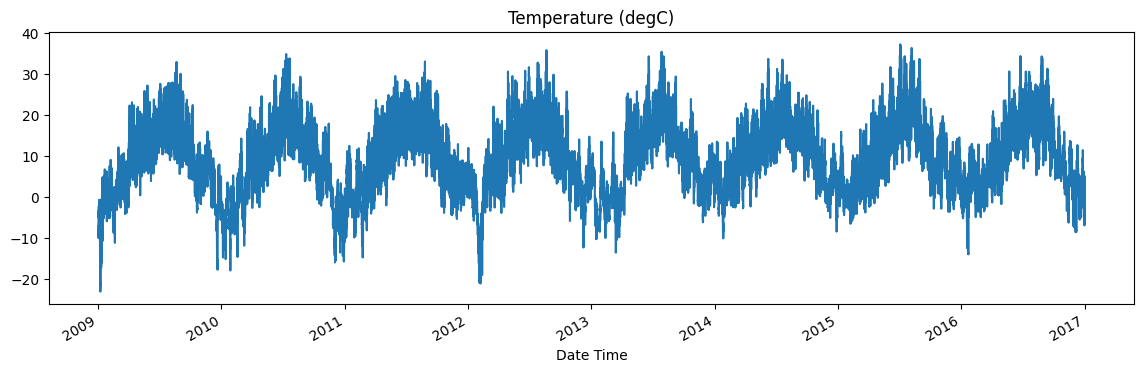

In [ ]:
import matplotlib.pyplot as plt

# Parse date
df['Date Time'] = pd.to_datetime(df['Date Time'],format="%d.%m.%Y %H:%M:%S")
df = df.set_index('Date Time').sort_index()

print("Columns:", df.columns.tolist())

# Plot temperature
df['T (degC)'].plot(figsize=(14,4), title='Temperature (degC)')
plt.show()

In [ ]:
# check missing
print("Any nulls?", df.isnull().any().any())

Any nulls? False


The dataset has 420551 rows and the difference between each row (each datapoint) is 10 minutes compared to the previous row. So there is 144 datapoints for each day. There are datapoints for 2920 days. I modify the dataset in a way to make an average from all datapoints for each day and import one row with average data for each day and then have 2920 rows.

# Average Daily Temperature Calculation

In [ ]:
# Keep only numeric columns
numeric_cols = df.select_dtypes(include='number')

# Daily averaging
df_daily = numeric_cols.resample('D').mean()

print("Daily dataset shape:", df_daily.shape)
df_daily.head()

Daily dataset shape: (2923, 14)


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01,999.145594,-6.810629,266.414545,-8.015594,91.086014,3.691119,3.355524,0.335315,2.091049,3.357832,1305.178252,0.778601,1.378252,181.863077
2009-01-02,999.600625,-3.728194,269.463194,-4.824861,92.086806,4.640069,4.267292,0.373056,2.659792,4.268750,1290.353194,1.419514,2.227361,125.072014
2009-01-03,998.548611,-5.271736,268.002292,-9.015833,76.458056,4.184792,3.107708,1.077014,1.937778,3.111944,1297.117014,1.250903,2.065069,190.383333
2009-01-04,988.510694,-1.375208,272.685347,-2.897014,89.417361,5.524306,4.938958,0.584861,3.114028,4.997014,1264.634514,1.720417,3.564861,213.069861
2009-01-05,990.405694,-4.867153,269.039306,-6.797292,86.260417,4.362708,3.806736,0.555625,2.397014,3.847778,1284.372778,3.800278,5.940000,118.287361


In [ ]:
# check missing
print("Any nulls?", df_daily.isnull().any().any())

Any nulls? True


In [ ]:
# Drop rows containing Nans

df_daily = df_daily.dropna()

# Train, Validation, and Test Split

In [ ]:
# split times (time-based split) and scale

import numpy as np
from sklearn.preprocessing import StandardScaler

data = df_daily.values.astype(np.float32)
num_samples = len(data)
train_frac = 0.75
val_frac = 0.15  # test will be remaining 0.10

train_end = int(num_samples * train_frac)
val_end = int(num_samples * (train_frac + val_frac))
print("train_end:", train_end, "val_end:", val_end, "total:", num_samples)

# Fit StandardScaler on training portion only
scaler = StandardScaler()
scaler.fit(data[:train_end])
data_scaled = scaler.transform(data)

column_names = df.columns.tolist()
target_col = column_names.index('T (degC)')
print("Target column index:", target_col, "->", column_names[target_col])

train_end: 2190 val_end: 2628 total: 2921
Target column index: 1 -> T (degC)


# Sliding Windows

In [ ]:
# create sliding windows
past_history = 10   # number of past timesteps (last 10 days)
future_target = 1   # predict the next day
STEP = 1            # sampling step inside window

def create_windows(data_scaled, start_idx, end_idx, past_history=past_history, future_target=future_target, step=STEP):
    X = []
    y = []
    for i in range(start_idx + past_history, end_idx - future_target):
        idxs = range(i - past_history, i, step)
        X.append(data_scaled[list(idxs)])
        y.append(data_scaled[i + future_target][target_col])  # scaled scalar
    return np.array(X), np.array(y)

# build train/val/test arrays (small check: not for huge memory)
X_train, y_train = create_windows(data_scaled, 0, train_end)
X_val,   y_val   = create_windows(data_scaled, train_end, val_end)
X_test,  y_test  = create_windows(data_scaled, val_end, num_samples)

print("Shapes -> X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "X_test:", X_test.shape)
# show one example (denormalize target to real °C)
t_mean, t_std = scaler.mean_[target_col], np.sqrt(scaler.var_[target_col])
print("Example scaled y_train[0]:", y_train[0], "denorm:", y_train[0]*t_std + t_mean, "°C")

Shapes -> X_train: (2179, 10, 14) y_train: (2179,)
X_val: (427, 10, 14) X_test: (282, 10, 14)
Example scaled y_train[0]: -1.829497 denorm: -5.3848610895169955 °C


# Final Preparation before Training

In [ ]:
# convert to tf.data.Dataset and apply performance ops

import tensorflow as tf

BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def make_tf_dataset(X, y, batch_size=BATCH_SIZE, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.cache().shuffle(10000)
    else:
        ds = ds.cache()
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

train_ds = make_tf_dataset(X_train, y_train, batch_size=BATCH_SIZE, shuffle=True)
val_ds   = make_tf_dataset(X_val,   y_val,   batch_size=BATCH_SIZE, shuffle=False)
test_ds  = make_tf_dataset(X_test,  y_test,  batch_size=BATCH_SIZE, shuffle=False)

# Inspect one batch to see shapes
for X_batch, y_batch in train_ds.take(1):
    print("X_batch shape:", X_batch.shape)  # (batch, timesteps, features)
    print("y_batch shape:", y_batch.shape)
    break

X_batch shape: (32, 10, 14)
y_batch shape: (32,)


# Persistence baseline

The simplest possible **model** for time series.

Assume the next day’s value will be the same as the last observed value in your input window.

In [ ]:
# persistence baseline

def persistence_baseline_mae(X, y, scaler):
    # X contains sequences; last observed temperature in scaled units is X[:, -1, target_col]
    preds = X[:, -1, target_col]
    mae_scaled = np.mean(np.abs(preds - y))
    # denormalize
    mean = scaler.mean_[target_col]
    std  = np.sqrt(scaler.var_[target_col])
    return mae_scaled * std

print("Persistence baseline MAE (train):", persistence_baseline_mae(X_train, y_train, scaler))
print("Persistence baseline MAE (val):  ", persistence_baseline_mae(X_val, y_val, scaler))
print("Persistence baseline MAE (test): ", persistence_baseline_mae(X_test, y_test, scaler))

Persistence baseline MAE (train): 2.8007940122023656
Persistence baseline MAE (val):   2.8959022636909406
Persistence baseline MAE (test):  2.6905784164567708


This is a **baseline dense** model for time-series prediction, but it flattens the sequence, so it **doesn’t** use the temporal structure explicitly.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers, callbacks, metrics

input_shape = (past_history, X_train.shape[-1])

# Define the baseline dense model
baseline = keras.Sequential([
    layers.Input(shape=input_shape),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

# Compile the model
baseline.compile(optimizer='adam', loss='mse', metrics=[metrics.MeanAbsoluteError()])

baseline.summary()

# Early stopping callback
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',      # monitor validation loss
    patience=10,             # stop if no improvement after 10 epochs
    restore_best_weights=True
)

# Train the model with up to 100 epochs
history_baseline = baseline.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate on test set after training
test_metrics = baseline.evaluate(test_ds, verbose=1)
print("Test Loss (MSE) and MAE:", test_metrics)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 140)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        18,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,369 (103.00 KB)

 Trainable params: 26,369 (103.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.3978 - mean_absolute_error: 0.5056 - val_loss: 27.8140 - val_mean_absolute_error: 1.0136
Epoch 2/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2264 - mean_absolute_error: 0.3766 - val_loss: 17.6894 - val_mean_absolute_error: 0.9287
Epoch 3/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1958 - mean_absolute_error: 0.3510 - val_loss: 19.9630 - val_mean_absolute_error: 0.9593
Epoch 4/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1772 - mean_absolute_error: 0.3293 - val_loss: 33.8260 - val_mean_absolute_error: 1.0853
Epoch 5/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1709 - mean_absolute_error: 0.3293 - val_loss: 35.7898 - val_mean_absolute_error: 1.1307
Epoch 6/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1587 - mean_absolute_error: 0.3158 - val_loss: 45.5119 - val_mean_absolute_error: 1.1946
Epoch 7/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1554 - mean_absolute_error: 0.3126 - v

# LSTM Model

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers, optimizers, metrics, callbacks

input_shape = (past_history, X_train.shape[-1])

# Define the LSTM model
lstm_model = keras.Sequential([
    layers.Input(shape=input_shape),             # input shape: (timesteps, features)
    layers.LSTM(64, return_sequences=False),    # LSTM layer with 64 units, outputs last hidden state
    layers.Dropout(0.2),                        # Dropout layer to prevent overfitting
    layers.Dense(32, activation='relu'),        # Fully connected layer to learn patterns after LSTM
    layers.Dense(1)                              # Output layer: predicts next day's temperature
])

# Compile the model
lstm_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),  # Adam optimizer with learning rate 0.001
    loss='mse',                                     # Mean Squared Error loss for regression
    metrics=[metrics.MeanAbsoluteError()]           # MAE to interpret model error in original units
)

lstm_model.summary()

# Early stopping callback
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',      # monitor validation loss
    patience=10,             # stop if no improvement in 10 epochs
    restore_best_weights=True
)

# Train the model
history_lstm = lstm_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,              # maximum epochs; early stopping will stop earlier if needed
    callbacks=[early_stop],
    verbose=1
)

# Evaluate on test set
test_metrics = lstm_model.evaluate(test_ds, verbose=1)
print("Test Loss (MSE) and MAE:", test_metrics)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,337 (87.25 KB)

 Trainable params: 22,337 (87.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.3287 - mean_absolute_error: 0.4499 - val_loss: 0.2163 - val_mean_absolute_error: 0.3813
Epoch 2/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1938 - mean_absolute_error: 0.3522 - val_loss: 0.2079 - val_mean_absolute_error: 0.3678
Epoch 3/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1934 - mean_absolute_error: 0.3497 - val_loss: 0.1999 - val_mean_absolute_error: 0.3586
Epoch 4/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1760 - mean_absolute_error: 0.3343 - val_loss: 0.1904 - val_mean_absolute_error: 0.3538
Epoch 5/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1637 - mean_absolute_error: 0.3236 - val_loss: 0.1912 - val_mean_absolute_error: 0.3544
Epoch 6/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1714 - mean_absolute_error: 0.3299 - val_loss: 0.1907 - val_mean_absolute_error: 0.3534
Epoch 7/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1685 - mean_absolute_error: 0.3256 - val_loss

# Optimized LSTM Model

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers, optimizers, metrics, callbacks

input_shape = (past_history, X_train.shape[-1])  # e.g., (10, 14)

# Stronger stacked LSTM model
strong_lstm = keras.Sequential([
    layers.Input(shape=input_shape),

    # First LSTM layer (returns full sequence for next LSTM)
    layers.LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),

    # Second LSTM layer (outputs last hidden state)
    layers.LSTM(32, return_sequences=False, dropout=0.2, recurrent_dropout=0.2),

    # Fully connected layer to combine features
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),

    # Output layer: predicts next day temperature
    layers.Dense(1)
])

# Compile the model
strong_lstm.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),  # starting learning rate
    loss='mse',                                     # regression loss
    metrics=[metrics.MeanAbsoluteError()]           # easy-to-interpret metric in °C
)

strong_lstm.summary()

# Early stopping callback
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',        # stop when validation loss stops improving
    patience=10,               # wait 10 epochs before stopping
    restore_best_weights=True  # keep the best model weights
)

# Train the model (max 100 epochs, early stopping will stop earlier)
history_strong_lstm = strong_lstm.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate on test set
test_metrics = strong_lstm.evaluate(test_ds, verbose=1)
print("Test Loss (MSE) and MAE:", test_metrics)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,729 (131.75 KB)

 Trainable params: 33,729 (131.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - loss: 0.5740 - mean_absolute_error: 0.5793 - val_loss: 0.2688 - val_mean_absolute_error: 0.4185
Epoch 2/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.2921 - mean_absolute_error: 0.4273 - val_loss: 0.2285 - val_mean_absolute_error: 0.3829
Epoch 3/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.2534 - mean_absolute_error: 0.4032 - val_loss: 0.2214 - val_mean_absolute_error: 0.3810
Epoch 4/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.2263 - mean_absolute_error: 0.3751 - val_loss: 0.2144 - val_mean_absolute_error: 0.3739
Epoch 5/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.2271 - mean_absolute_error: 0.3760 - val_loss: 0.2077 - val_mean_absolute_error: 0.3724
Epoch 6/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.2410 - mean_absolute_error: 0.3846 - val_loss: 0.2073 - val_mean_absolute_error: 0.3633
Epoch 7/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.2290 - mean_absolute_error: 0.3818 - 

# GRU Model

In [ ]:
input_shape = (past_history, X_train.shape[-1])  # (timesteps, features)

#  GRU model
gru_model = keras.Sequential([
    layers.Input(shape=input_shape),

    # First GRU layer (returns full sequence)
    layers.GRU(
        64,
        return_sequences=True,
        dropout=0.2,
        recurrent_dropout=0.2
    ),

    # Second GRU layer (returns last hidden state)
    layers.GRU(
        32,
        return_sequences=False,
        dropout=0.2,
        recurrent_dropout=0.2
    ),

    # Dense layers for regression head
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),

    # Output: next-day temperature
    layers.Dense(1)
])

# Compile
gru_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='mse',
    metrics=[metrics.MeanAbsoluteError()]
)

gru_model.summary()

# Early stopping
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train
history_gru = gru_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate
test_metrics = gru_model.evaluate(test_ds, verbose=1)
print("GRU Test Loss (MSE) and MAE:", test_metrics)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 10, 64)         │        15,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,857 (101.00 KB)

 Trainable params: 25,857 (101.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: 0.5143 - mean_absolute_error: 0.5510 - val_loss: 0.2112 - val_mean_absolute_error: 0.3685
Epoch 2/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.2709 - mean_absolute_error: 0.4110 - val_loss: 0.2173 - val_mean_absolute_error: 0.3745
Epoch 3/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.2622 - mean_absolute_error: 0.4016 - val_loss: 0.2080 - val_mean_absolute_error: 0.3681
Epoch 4/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.2389 - mean_absolute_error: 0.3861 - val_loss: 0.1930 - val_mean_absolute_error: 0.3545
Epoch 5/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.2342 - mean_absolute_error: 0.3804 - val_loss: 0.1999 - val_mean_absolute_error: 0.3625
Epoch 6/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.2240 - mean_absolute_error: 0.3756 - val_loss: 0.1891 - val_mean_absolute_error: 0.3501
Epoch 7/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.2192 - mean_absolute_error: 0.3738 - v

# 1D CNN Model

In [ ]:
input_shape = (past_history, X_train.shape[-1])  # (timesteps, features)

#  1D-CNN model
cnn_model = keras.Sequential([
    layers.Input(shape=input_shape),

    # First temporal convolution
    layers.Conv1D(
        filters=64,           # number of temporal filters
        kernel_size=3,        # looks at 3 consecutive days
        activation='relu',
        padding='causal'      # prevents leakage from future
    ),
    layers.BatchNormalization(),

    # Second temporal convolution
    layers.Conv1D(
        filters=32,
        kernel_size=3,
        activation='relu',
        padding='causal'
    ),
    layers.BatchNormalization(),

    # Downsampling temporal dimension
    layers.MaxPooling1D(pool_size=2),

    # Flatten temporal features
    layers.Flatten(),

    # Dense regression head
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),

    # Output layer
    layers.Dense(1)
])

# Compile
cnn_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='mse',
    metrics=[metrics.MeanAbsoluteError()]
)

cnn_model.summary()

# Early stopping
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train
history_cnn = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate
test_metrics = cnn_model.evaluate(test_ds, verbose=1)
print("CNN Test Loss (MSE) and MAE:", test_metrics)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 10, 64)         │         2,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 10, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 10, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,681 (76.88 KB)

 Trainable params: 19,489 (76.13 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - loss: 1.5946 - mean_absolute_error: 0.9736 - val_loss: 80.9855 - val_mean_absolute_error: 1.6138
Epoch 2/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4465 - mean_absolute_error: 0.5206 - val_loss: 99.7339 - val_mean_absolute_error: 1.6730
Epoch 3/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3206 - mean_absolute_error: 0.4517 - val_loss: 148.9036 - val_mean_absolute_error: 1.8780
Epoch 4/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2748 - mean_absolute_error: 0.4167 - val_loss: 145.8992 - val_mean_absolute_error: 1.8318
Epoch 5/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2473 - mean_absolute_error: 0.3931 - val_loss: 154.8220 - val_mean_absolute_error: 1.9244
Epoch 6/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2353 - mean_absolute_error: 0.3839 - val_loss: 167.0692 - val_mean_absolute_error: 1.9941
Epoch 7/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2504 - mean_absolute_error: 0.3962

# Visualized Evaluation

/tmp/ipython-input-3172200557.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


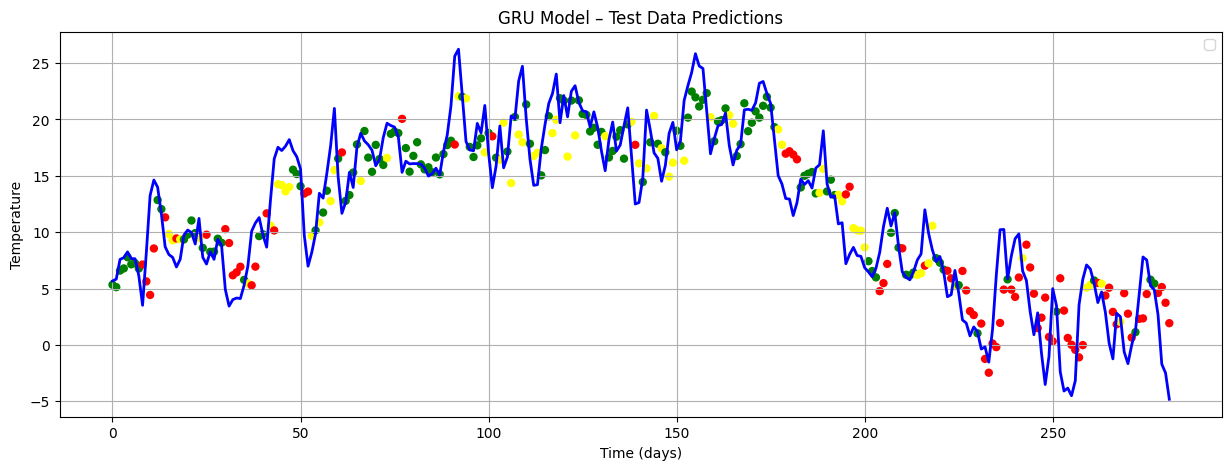

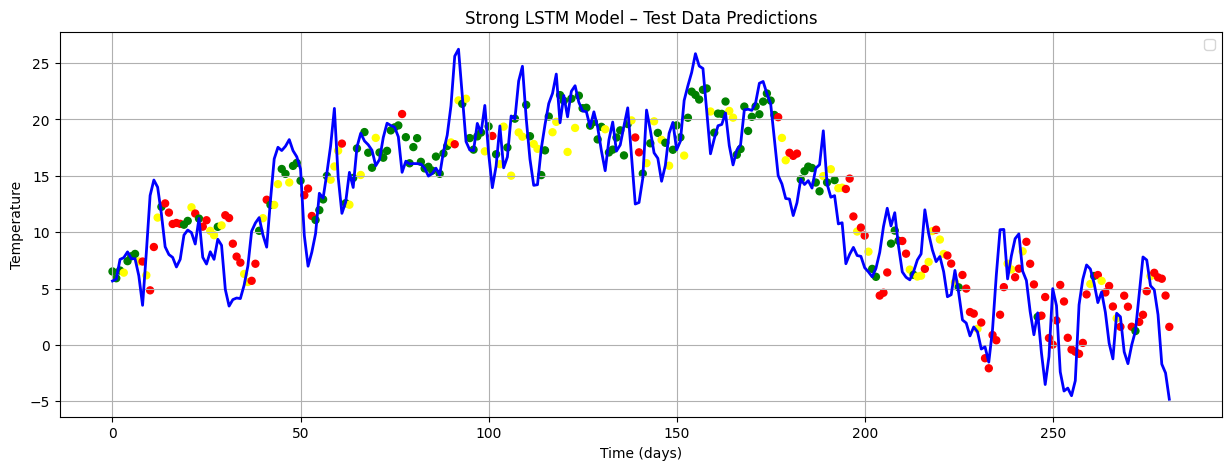

In [ ]:

# -------- helper: get real & predicted values (denormalized) --------
def get_real_and_pred(model, dataset, scaler, target_col):
    y_true_scaled = []
    y_pred_scaled = []

    for X_batch, y_batch in dataset:
        y_true_scaled.append(y_batch.numpy())
        y_pred_scaled.append(model.predict(X_batch, verbose=0))

    y_true_scaled = np.concatenate(y_true_scaled).ravel()
    y_pred_scaled = np.concatenate(y_pred_scaled).ravel()

    # inverse scaling (only target column)
    mean = scaler.mean_[target_col]
    std  = np.sqrt(scaler.var_[target_col])

    y_true = y_true_scaled * std + mean
    y_pred = y_pred_scaled * std + mean

    return y_true, y_pred


# -------- helper: plot with error-based coloring --------
def plot_predictions(y_true, y_pred, title):
    pct_error = np.abs(y_pred - y_true) / np.abs(y_true) * 100

    colors = np.where(
        pct_error < 15, 'green',
        np.where(pct_error < 30, 'yellow', 'red')
    )

    plt.figure(figsize=(15, 5))
    plt.plot(y_true, color='blue', linewidth=2)
    plt.scatter(range(len(y_pred)), y_pred, c=colors, s=25)

    plt.title(title)
    plt.xlabel("Time (days)")
    plt.ylabel("Temperature")
    plt.legend()
    plt.grid(True)
    plt.show()


# -------- GRU plot --------
y_true_gru, y_pred_gru = get_real_and_pred(
    gru_model, test_ds, scaler, target_col
)

plot_predictions(
    y_true_gru,
    y_pred_gru,
    "GRU Model – Test Data Predictions"
)


# -------- Strong LSTM plot --------
y_true_lstm, y_pred_lstm = get_real_and_pred(
    strong_lstm, test_ds, scaler, target_col
)

plot_predictions(
    y_true_lstm,
    y_pred_lstm,
    "Strong LSTM Model – Test Data Predictions"
)

## Save the Best Model (GRU), based on the performance.

In [ ]:
# Save GRU model

gru_model.save("gru_temperature_model.keras")

## Save the Scaler

In [ ]:
import pickle

scaler_path = "/content/drive/MyDrive/LLM/Temp_TimeSeries_LLM/temperature_scaler.pkl"

with open(scaler_path, "wb") as f:
    pickle.dump(scaler, f)

## Save the metadata

In [ ]:
metadata = {
    "past_history": past_history,
    "future_target": future_target,
    "step": STEP,
    "target_column": "T (degC)",
    "target_col_index": target_col,
    "feature_columns": df_daily.columns.tolist(),
    "sampling_frequency": "1 day",
    "model_type": "GRU",
    "dataset": "Daily averaged temperature + climate features",
    "scaler_type": "StandardScaler"
}

import json

metadata_path = "/content/drive/MyDrive/LLM/Temp_TimeSeries_LLM/temperature_metadata.json"

with open(metadata_path, "w") as f:
    json.dump(metadata, f, indent=4)

The developed model is saved in a suitable way to be used for an **Agentic AI** project. The project's coding is provided in Part 2 of this notebook.